In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

/Users/baiyusha/Desktop/SBU/AMS595/final group project/.venv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read panel
panel = pd.read_csv("panel.csv")
print("Loaded panel.csv:", panel.shape)

Loaded panel.csv: (15576, 18)


In [3]:
# feature
FEATURES = [
    "relig", "civic", "bus", "prof", "labor", "sport",
    "bowl", "golf", "assn", "pvote", "respn", "nccs", "pop",
    "political", "year"
]

TARGET = "sk"

# Train = 1990-2009, Test = 2014
train = panel[panel["year"] < 2014].copy()
test  = panel[panel["year"] == 2014].copy()

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [4]:
# XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse",
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("\n=== XGBoost Performance on 2014 ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")

# Feature importance
importances = xgb_model.feature_importances_
feat_imp = sorted(zip(FEATURES, importances), key=lambda x: x[1], reverse=True)

print("\n=== Feature Importances ===")
for name, score in feat_imp:
    print(f"{name:10s} : {score:.4f}")


=== XGBoost Performance on 2014 ===
RMSE: 0.4266
MAE : 0.3642
R^2 : 0.8855

=== Feature Importances ===
pvote      : 0.2457
assn       : 0.2408
respn      : 0.1601
pop        : 0.0971
nccs       : 0.0593
bowl       : 0.0485
relig      : 0.0372
civic      : 0.0362
year       : 0.0302
bus        : 0.0115
prof       : 0.0095
labor      : 0.0095
political  : 0.0089
golf       : 0.0037
sport      : 0.0020


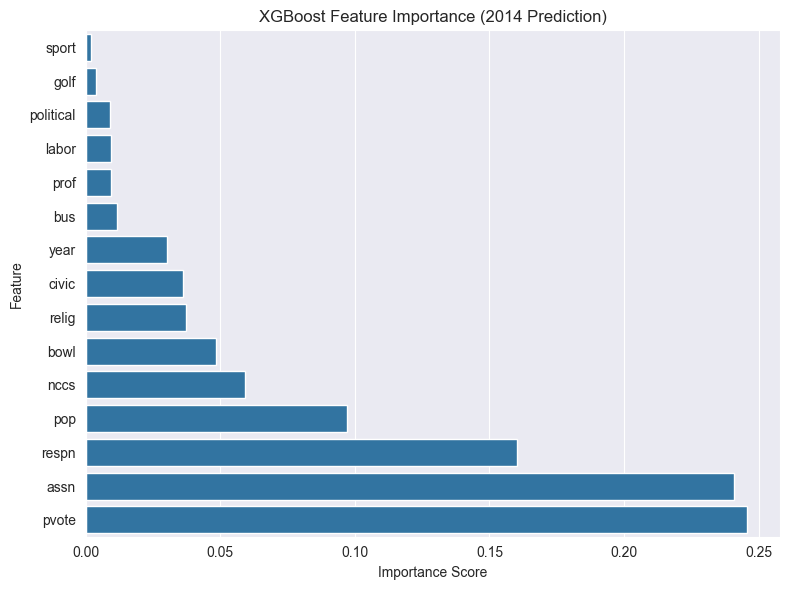

In [5]:
# sort
feat_imp_sorted = sorted(zip(FEATURES, importances), key=lambda x: x[1])

names  = [x[0] for x in feat_imp_sorted]
scores = [x[1] for x in feat_imp_sorted]

plt.figure(figsize=(8, 6))
sns.barplot(x=scores, y=names)
plt.title("XGBoost Feature Importance (2014 Prediction)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

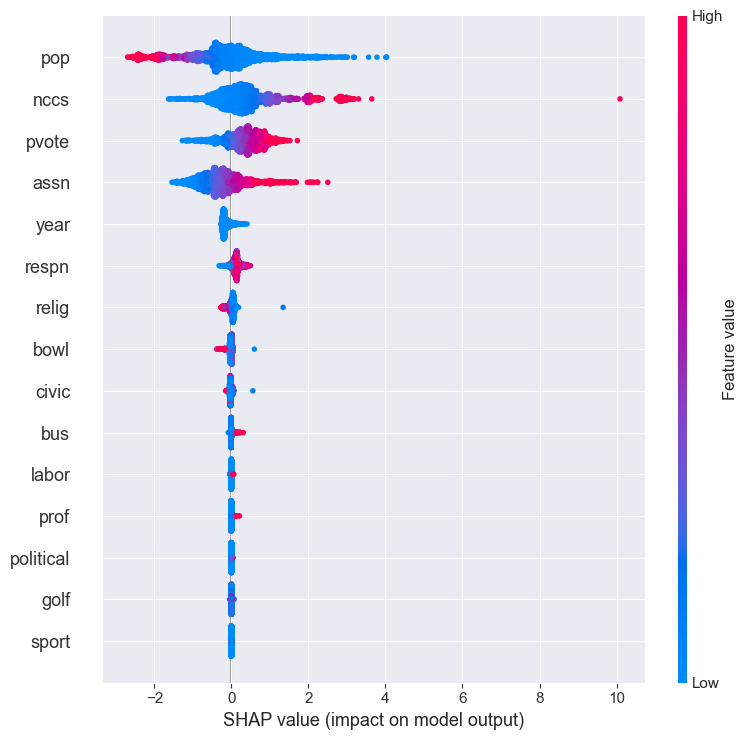

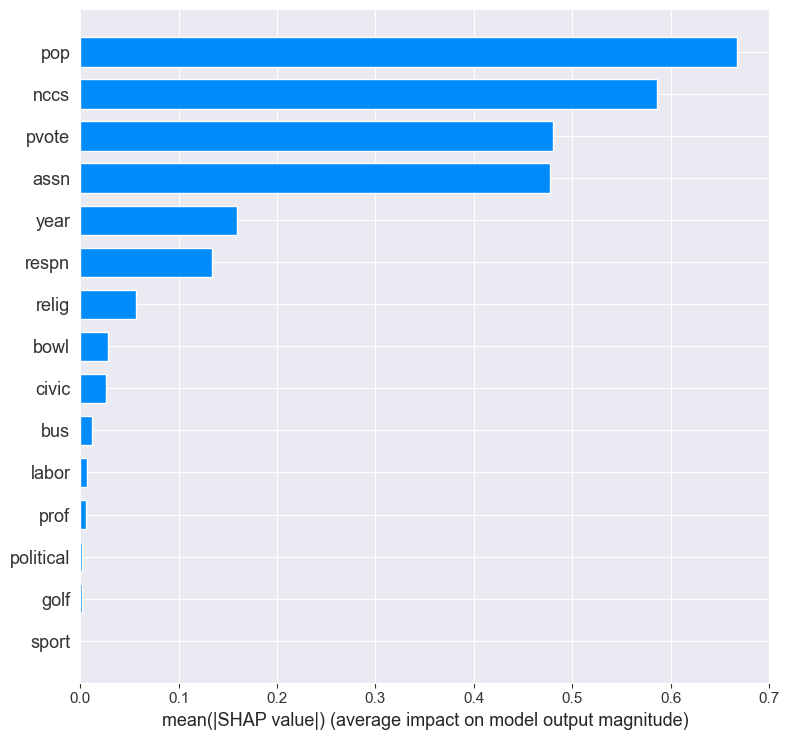

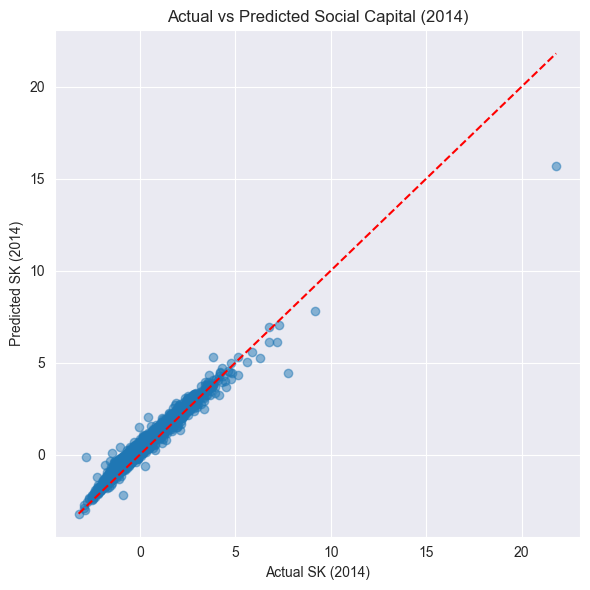

In [6]:
# shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# --- Summary Plot ---
shap.summary_plot(shap_values, X_test, plot_type="dot")

# --- Bar Plot ---
shap.summary_plot(shap_values, X_test, plot_type="bar")

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual SK (2014)")
plt.ylabel("Predicted SK (2014)")
plt.title("Actual vs Predicted Social Capital (2014)")

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.tight_layout()
plt.show()

In [7]:
years = [1990, 1997, 2005, 2009, 2014]
results = []

for i in range(1, len(years)):
    train_years = years[:i]
    test_year = years[i]

    train_df = panel[panel["year"].isin(train_years)]
    test_df  = panel[panel["year"] == test_year]

    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]

    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([train_years[-1], test_year, rmse, r2])

# output
print("\n=== Panel Time-Series Cross Validation ===")
for r in results:
    print(f"Train ≤ {r[0]}, Test = {r[1]} | RMSE = {r[2]:.4f}, R² = {r[3]:.4f}")


=== Panel Time-Series Cross Validation ===
Train ≤ 1990, Test = 1997 | RMSE = 3.2076, R² = -3.9755
Train ≤ 1997, Test = 2005 | RMSE = 0.4522, R² = 0.8946
Train ≤ 2005, Test = 2009 | RMSE = 0.5015, R² = 0.8595
Train ≤ 2009, Test = 2014 | RMSE = 0.4266, R² = 0.8855
